In [1]:
!git clone https://github.com/colome8/DAE-VAE.git

fatal: destination path 'DAE-VAE' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PREPROCESAMIENTO

In [3]:
!pip install --upgrade wandb

In [3]:
%pip install tensorflow==2.12.0

In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
# Install wandb with Keras support:
import wandb
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger
import getpass
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

In [5]:
# Definir parámetros
IMG_SIZE = (128, 128)  # Tamaño estándar de imagen
DATASET_PATH = "/content/DAE-VAE/filtered_images"  # Ruta en Google Colab

# CLAHE (Equalización adaptativa del histograma)
def clahe_equalization(img):
    img_uint8 = (img * 255).astype(np.uint8)  # Asegurar formato correcto
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final.astype(np.float32) / 255.0

# Función para cargar y preprocesar imágenes
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalización (0-1)
            img_eq = clahe_equalization(img_array)  # Equalización de histograma
            images.append(img_eq)
            labels.append(label)
        except Exception as e:
            print(f"Error cargando imagen {filename}: {e}")
    return images, labels

# Cargar imágenes de ambas clases
apples_images, apples_labels = load_images_from_folder(os.path.join(DATASET_PATH, "apples"), label=0)
bananas_images, bananas_labels = load_images_from_folder(os.path.join(DATASET_PATH, "bananas"), label=1)

# Combinar datos
X = np.array(apples_images + bananas_images)
y = np.array(apples_labels + bananas_labels)

# Dividir en conjunto de entrenamiento (70%), validación (15%) y prueba (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Guardar datos preprocesados en formato .npz
np.savez_compressed("/content/preprocessed_dataset.npz", X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

print("Preprocesamiento completado. Dataset guardado como 'preprocessed_dataset.npz'")


Preprocesamiento completado. Dataset guardado como 'preprocessed_dataset.npz'


---
## DAE

In [6]:
# 🔐 Login y setup de W&B
WANDB_API_KEY = getpass.getpass("Ingresa tu W&B API Key (oculto): ")
wandb.login(key=WANDB_API_KEY)

Ingresa tu W&B API Key (oculto): ··········


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: juan-colome (juan-colome-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
wandb.init(project="DAE-VAE",
    name="DAE-gaussian-10")

In [8]:
def add_noise(images, noise_type="gaussian", mean=0, var=0.01, salt_prob=0.02, pepper_prob=0.02):
    noisy = []
    for img in images:
        if noise_type == "gaussian":
            row, col, ch = img.shape
            sigma = var ** 0.5
            gauss = np.random.normal(mean, sigma, (row, col, ch))
            noisy_img = img + gauss
            noisy_img = np.clip(noisy_img, 0, 1)

        elif noise_type == "salt_pepper":
            noisy_img = np.copy(img)
            total_pixels = img.shape[0] * img.shape[1]
            num_salt = int(total_pixels * salt_prob)
            coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
            noisy_img[coords[0], coords[1], :] = 1
            num_pepper = int(total_pixels * pepper_prob)
            coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
            noisy_img[coords[0], coords[1], :] = 0

        else:
            noisy_img = img  # no noise
        noisy.append(noisy_img)
    return np.array(noisy)


In [9]:
# 📦 Agregar ruido a las imágenes
X_train_noisy = add_noise(X_train, noise_type="gaussian")
X_val_noisy   = add_noise(X_val, noise_type="gaussian")
X_test_noisy  = add_noise(X_test, noise_type="gaussian")


In [10]:
def build_autoencoder(input_shape=(128, 128, 3), latent_dim=128):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(latent_dim, name="latent_vector")(x)

    # Decoder
    x = layers.Dense(32 * 32 * 64, activation="relu")(encoded)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    autoencoder = keras.Model(inputs, decoded)
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss="binary_crossentropy")


In [11]:
early_stop = EarlyStopping(
      monitor='val_loss',
      patience=4,  # Espera 4 epochs sin mejora
      restore_best_weights=True
    )

In [12]:
# Asume que ya tienes: X_train, X_val, X_train_noisy, X_val_noisy
history = autoencoder.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=30,
    batch_size=32,
    callbacks=[WandbMetricsLogger(), early_stop]
)

Epoch 1/30
14/14 [==============================] - 39s 3s/step - loss: 0.6500 - val_loss: 0.6004
Epoch 2/30
14/14 [==============================] - 38s 3s/step - loss: 0.5929 - val_loss: 0.5642
Epoch 3/30
14/14 [==============================] - 37s 3s/step - loss: 0.5679 - val_loss: 0.5513
Epoch 4/30
14/14 [==============================] - 36s 3s/step - loss: 0.5592 - val_loss: 0.5424
Epoch 5/30
14/14 [==============================] - 35s 3s/step - loss: 0.5513 - val_loss: 0.5350
Epoch 6/30
14/14 [==============================] - 37s 3s/step - loss: 0.5467 - val_loss: 0.5296
Epoch 7/30
14/14 [==============================] - 35s 3s/step - loss: 0.5413 - val_loss: 0.5270
Epoch 8/30
14/14 [==============================] - 37s 3s/step - loss: 0.5378 - val_loss: 0.5255
Epoch 9/30
14/14 [==============================] - 35s 3s/step - loss: 0.5323 - val_loss: 0.5176
Epoch 10/30
14/14 [==============================] - 36s 3s/step - loss: 0.5263 - val_loss: 0.5150
Epoch 11/30
14/14 [

In [13]:
os.makedirs("models", exist_ok=True)
autoencoder.save("models/dae_model.h5", include_optimizer=False)
wandb.save("dae_model.h5")

[]

In [14]:
wandb.finish()

In [15]:
import matplotlib.pyplot as plt

def mostrar_resultados(idx=0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Imagen original
    axs[0].imshow(X_test[idx])
    axs[0].set_title("Original")
    axs[0].axis("off")

    # Imagen con ruido
    axs[1].imshow(X_test_noisy[idx])
    axs[1].set_title("Con ruido")
    axs[1].axis("off")

    # Imagen restaurada por el modelo
    restored = autoencoder.predict(X_test_noisy[idx:idx+1])[0]
    axs[2].imshow(restored)
    axs[2].set_title("Restaurada")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 156ms/step


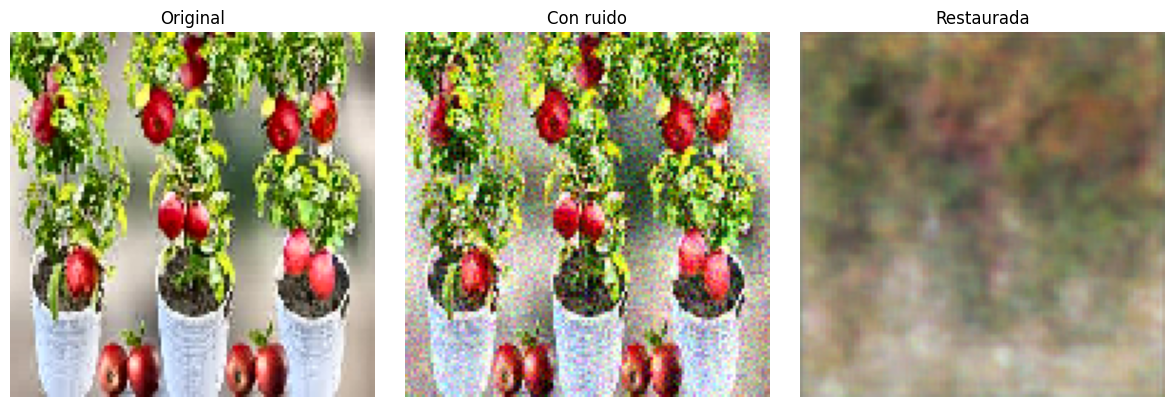

In [16]:
mostrar_resultados(81)

1/1 [==============================] - 0s 56ms/step


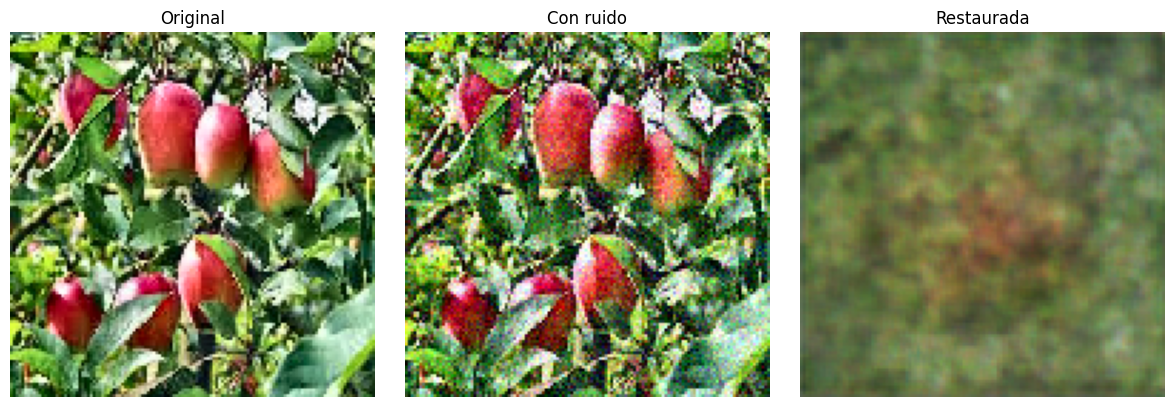

In [17]:
mostrar_resultados(5)

1/1 [==============================] - 0s 58ms/step


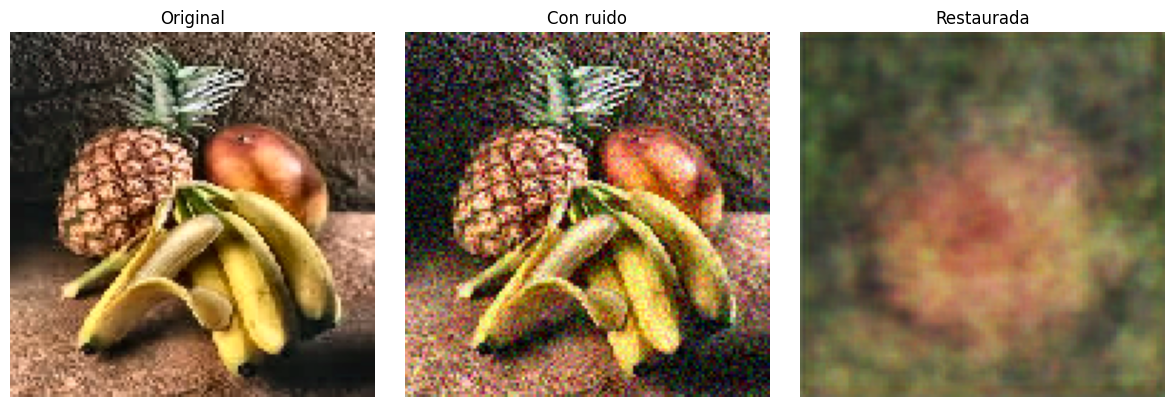

In [18]:
mostrar_resultados(64)

In [21]:
files.download("models/dae_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## VAE

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from scipy.linalg import sqrtm
import wandb
from wandb.integration.keras import WandbMetricsLogger

In [ ]:
# -------------------------------
# 1. Configurar W&B
# -------------------------------
WANDB_API_KEY = getpass.getpass("🔑 Ingresa tu W&B API Key (oculto): ")
wandb.login(key=WANDB_API_KEY)

In [23]:
wandb.init(project="DAE-VAE", name="VAE_15")

In [24]:
# -------------------------------
# 1. Callback para FID e imágenes
# -------------------------------
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def resize_images_for_fid(images):
    images_resized = tf.image.resize(images, (299, 299))
    return preprocess_input(images_resized)

def calculate_fid(real_images, generated_images):
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)
    real_images_pp = resize_images_for_fid(real_images)
    gen_images_pp = resize_images_for_fid(generated_images)
    act1 = inception_model.predict(real_images_pp, batch_size=32, verbose=0)
    act2 = inception_model.predict(gen_images_pp, batch_size=32, verbose=0)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

class ImageLoggerCallback(keras.callbacks.Callback):
    def __init__(self, decoder, latent_dim, real_images):
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.real_images = real_images

    def on_epoch_end(self, epoch, logs=None):
        z_sample = tf.random.normal(shape=(100, self.latent_dim))
        generated = self.decoder.predict(z_sample)
        fid = calculate_fid(self.real_images[:100], generated[:100])
        wandb.log({
            "sampled_image": wandb.Image(generated[0], caption=f"Epoch {epoch + 1}"),
            "FID": fid
        })

# -------------------------------
# 2. Modelo VAE con tamaño 128x128
# -------------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

input_shape = (128, 128, 3)
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation='relu')(latent_inputs)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

# -------------------------------
# 3. Modelo VAE
# -------------------------------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer, **kwargs):
        super(VAE, self).compile(optimizer=optimizer, **kwargs)
        self.optimizer = optimizer
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
              tf.keras.backend.binary_crossentropy(data, reconstruction), axis=[1, 2]))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
          tf.keras.backend.binary_crossentropy(data, reconstruction), axis=[1, 2]))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "val_loss": self.total_loss_tracker.result(),
            "val_reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "val_kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs, training=None, mask=None):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

# -------------------------------
# 4. Entrenamiento
# -------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

early_stop = EarlyStopping(
    monitor='val_reconstruction_loss',
    patience=3,
    restore_best_weights=True,
    mode='min'
)

vae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=30,
    batch_size=32,
    callbacks=[
        WandbMetricsLogger(),
        ImageLoggerCallback(decoder=decoder, latent_dim=latent_dim, real_images=X_test),
        early_stop
    ]
)

# -------------------------------
# 5. Guardar modelos por separado
# -------------------------------
os.makedirs("models", exist_ok=True)
encoder.save("models/vae_encoder.h5", include_optimizer=False)
decoder.save("models/vae_decoder.h5")
print("✅ ¡Modelos guardados por separado!")


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/30
4/4 [==============================] - 1s 243ms/step


14/14 [==============================] - 73s 5s/step - loss: 11143.2011 - reconstruction_loss: 10955.0322 - kl_loss: 9.5397 - val_val_loss: 10734.8086 - val_val_reconstruction_loss: 10734.7236 - val_val_kl_loss: 0.0850
Epoch 2/30
4/4 [==============================] - 1s 240ms/step


14/14 [==============================] - 76s 6s/step - loss: 10786.3950 - reconstruction_loss: 10616.3438 - kl_loss: 5.2520 - val_val_loss: 10281.3252 - val_val_reconstruction_loss: 10248.1992 - val_val_kl_loss: 33.1255
Epoch 3/30
4/4 [==============================] - 1s 251ms/step


14/14 [==============================] - 78s 6s/step - loss: 10015.6602 - reconstruction_loss: 9873.5479 - kl_loss: 55.4396 - val_val_loss: 9748.0869 - val_val_reconstruction_loss: 9702.6768 - val_val_kl_loss: 45.4111
Epoch 4/30
4/4 [==============================] - 1s 359ms/step


14/14 [==============================] - 78s 6s/step - loss: 9808.5906 - reconstruction_loss: 9675.0596 - kl_loss: 41.4733 - val_val_loss: 9433.1084 - val_val_reconstruction_loss: 9389.4795 - val_val_kl_loss: 43.6289
Epoch 5/30
4/4 [==============================] - 1s 251ms/step


14/14 [==============================] - 75s 6s/step - loss: 9586.1214 - reconstruction_loss: 9577.4609 - kl_loss: 35.0219 - val_val_loss: 9398.8604 - val_val_reconstruction_loss: 9358.8877 - val_val_kl_loss: 39.9721
Epoch 6/30
4/4 [==============================] - 1s 245ms/step


14/14 [==============================] - 77s 6s/step - loss: 9535.1734 - reconstruction_loss: 9457.3506 - kl_loss: 27.7535 - val_val_loss: 9261.8311 - val_val_reconstruction_loss: 9227.7451 - val_val_kl_loss: 34.0870
Epoch 7/30
4/4 [==============================] - 1s 249ms/step


14/14 [==============================] - 77s 6s/step - loss: 9495.1146 - reconstruction_loss: 9382.2744 - kl_loss: 31.2252 - val_val_loss: 9251.3896 - val_val_reconstruction_loss: 9209.6064 - val_val_kl_loss: 41.7836
Epoch 8/30
4/4 [==============================] - 1s 310ms/step


14/14 [==============================] - 77s 6s/step - loss: 9341.4321 - reconstruction_loss: 9318.7305 - kl_loss: 31.2413 - val_val_loss: 9058.0215 - val_val_reconstruction_loss: 9023.0029 - val_val_kl_loss: 35.0177
Epoch 9/30
4/4 [==============================] - 1s 245ms/step


14/14 [==============================] - 75s 6s/step - loss: 9200.7388 - reconstruction_loss: 9214.8701 - kl_loss: 30.0381 - val_val_loss: 8990.7578 - val_val_reconstruction_loss: 8952.4414 - val_val_kl_loss: 38.3159
Epoch 10/30
4/4 [==============================] - 1s 251ms/step


14/14 [==============================] - 76s 6s/step - loss: 9225.3283 - reconstruction_loss: 9159.6279 - kl_loss: 33.1397 - val_val_loss: 8914.3955 - val_val_reconstruction_loss: 8879.4971 - val_val_kl_loss: 34.8982
Epoch 11/30
4/4 [==============================] - 1s 249ms/step


14/14 [==============================] - 68s 5s/step - loss: 9080.2941 - reconstruction_loss: 9143.2627 - kl_loss: 37.2736 - val_val_loss: 8885.6133 - val_val_reconstruction_loss: 8839.5742 - val_val_kl_loss: 46.0394
Epoch 12/30
4/4 [==============================] - 1s 243ms/step


14/14 [==============================] - 75s 6s/step - loss: 9091.2208 - reconstruction_loss: 9090.1006 - kl_loss: 40.8823 - val_val_loss: 8899.1572 - val_val_reconstruction_loss: 8858.0654 - val_val_kl_loss: 41.0917
Epoch 13/30
4/4 [==============================] - 1s 239ms/step


14/14 [==============================] - 75s 6s/step - loss: 9147.1431 - reconstruction_loss: 9089.0537 - kl_loss: 38.5146 - val_val_loss: 8868.9307 - val_val_reconstruction_loss: 8826.4385 - val_val_kl_loss: 42.4912
Epoch 14/30
4/4 [==============================] - 1s 245ms/step


14/14 [==============================] - 77s 6s/step - loss: 9110.4327 - reconstruction_loss: 9067.0371 - kl_loss: 42.5297 - val_val_loss: 8879.7080 - val_val_reconstruction_loss: 8825.6963 - val_val_kl_loss: 54.0112
Epoch 15/30
4/4 [==============================] - 1s 249ms/step


14/14 [==============================] - 76s 6s/step - loss: 9026.6107 - reconstruction_loss: 9021.7881 - kl_loss: 46.4935 - val_val_loss: 8836.1953 - val_val_reconstruction_loss: 8787.6719 - val_val_kl_loss: 48.5228
Epoch 16/30
4/4 [==============================] - 2s 348ms/step


14/14 [==============================] - 71s 5s/step - loss: 9078.2865 - reconstruction_loss: 8976.6221 - kl_loss: 47.9011 - val_val_loss: 8759.6680 - val_val_reconstruction_loss: 8710.9307 - val_val_kl_loss: 48.7374
Epoch 17/30
4/4 [==============================] - 2s 385ms/step


14/14 [==============================] - 69s 5s/step - loss: 8946.5683 - reconstruction_loss: 8941.3457 - kl_loss: 49.6516 - val_val_loss: 8741.3604 - val_val_reconstruction_loss: 8689.8428 - val_val_kl_loss: 51.5188
Epoch 18/30
4/4 [==============================] - 1s 251ms/step


14/14 [==============================] - 76s 6s/step - loss: 8936.2973 - reconstruction_loss: 8881.2832 - kl_loss: 56.0607 - val_val_loss: 8683.9023 - val_val_reconstruction_loss: 8618.9600 - val_val_kl_loss: 64.9431
Epoch 19/30
4/4 [==============================] - 1s 383ms/step


14/14 [==============================] - 65s 5s/step - loss: 8789.8796 - reconstruction_loss: 8828.4717 - kl_loss: 61.3484 - val_val_loss: 8644.7920 - val_val_reconstruction_loss: 8579.2852 - val_val_kl_loss: 65.5066
Epoch 20/30
4/4 [==============================] - 1s 237ms/step


14/14 [==============================] - 75s 6s/step - loss: 8904.8615 - reconstruction_loss: 8810.3340 - kl_loss: 62.1286 - val_val_loss: 8656.5420 - val_val_reconstruction_loss: 8583.3154 - val_val_kl_loss: 73.2266
Epoch 21/30
4/4 [==============================] - 1s 260ms/step


14/14 [==============================] - 76s 6s/step - loss: 8895.2799 - reconstruction_loss: 8775.9346 - kl_loss: 68.2984 - val_val_loss: 8613.2920 - val_val_reconstruction_loss: 8552.1973 - val_val_kl_loss: 61.0948
Epoch 22/30
4/4 [==============================] - 1s 241ms/step


14/14 [==============================] - 72s 5s/step - loss: 8754.9275 - reconstruction_loss: 8797.3408 - kl_loss: 61.8715 - val_val_loss: 8605.6377 - val_val_reconstruction_loss: 8540.0811 - val_val_kl_loss: 65.5569
Epoch 23/30
4/4 [==============================] - 1s 257ms/step


14/14 [==============================] - 76s 6s/step - loss: 8908.7015 - reconstruction_loss: 8757.1689 - kl_loss: 68.8046 - val_val_loss: 8588.1455 - val_val_reconstruction_loss: 8515.8984 - val_val_kl_loss: 72.2479
Epoch 24/30
4/4 [==============================] - 1s 251ms/step


14/14 [==============================] - 73s 5s/step - loss: 8586.2313 - reconstruction_loss: 8745.1738 - kl_loss: 63.8419 - val_val_loss: 8618.8291 - val_val_reconstruction_loss: 8549.9307 - val_val_kl_loss: 68.8990
Epoch 25/30
4/4 [==============================] - 1s 244ms/step


14/14 [==============================] - 72s 5s/step - loss: 8834.1656 - reconstruction_loss: 8730.5791 - kl_loss: 69.4202 - val_val_loss: 8555.7158 - val_val_reconstruction_loss: 8483.8193 - val_val_kl_loss: 71.8970
Epoch 26/30
4/4 [==============================] - 2s 379ms/step


14/14 [==============================] - 78s 6s/step - loss: 8402.5922 - reconstruction_loss: 8665.7480 - kl_loss: 70.2514 - val_val_loss: 8537.7744 - val_val_reconstruction_loss: 8459.8389 - val_val_kl_loss: 77.9362
Epoch 27/30
4/4 [==============================] - 1s 254ms/step


14/14 [==============================] - 76s 6s/step - loss: 8696.0301 - reconstruction_loss: 8651.0303 - kl_loss: 72.9633 - val_val_loss: 8557.0625 - val_val_reconstruction_loss: 8473.5615 - val_val_kl_loss: 83.5014
Epoch 28/30
4/4 [==============================] - 1s 250ms/step


14/14 [==============================] - 77s 6s/step - loss: 8595.1471 - reconstruction_loss: 8655.9492 - kl_loss: 75.6960 - val_val_loss: 8594.0137 - val_val_reconstruction_loss: 8514.4209 - val_val_kl_loss: 79.5922
Epoch 29/30
4/4 [==============================] - 1s 260ms/step


14/14 [==============================] - 77s 6s/step - loss: 8724.3632 - reconstruction_loss: 8628.7832 - kl_loss: 80.3058 - val_val_loss: 8490.1338 - val_val_reconstruction_loss: 8408.0117 - val_val_kl_loss: 82.1215
Epoch 30/30
4/4 [==============================] - 2s 386ms/step


14/14 [==============================] - 78s 6s/step - loss: 8578.4969 - reconstruction_loss: 8575.8311 - kl_loss: 83.5567 - val_val_loss: 8509.2451 - val_val_reconstruction_loss: 8428.3994 - val_val_kl_loss: 80.8449


✅ ¡Modelos guardados por separado!


In [25]:
wandb.finish()

1/1 [==============================] - 0s 282ms/step


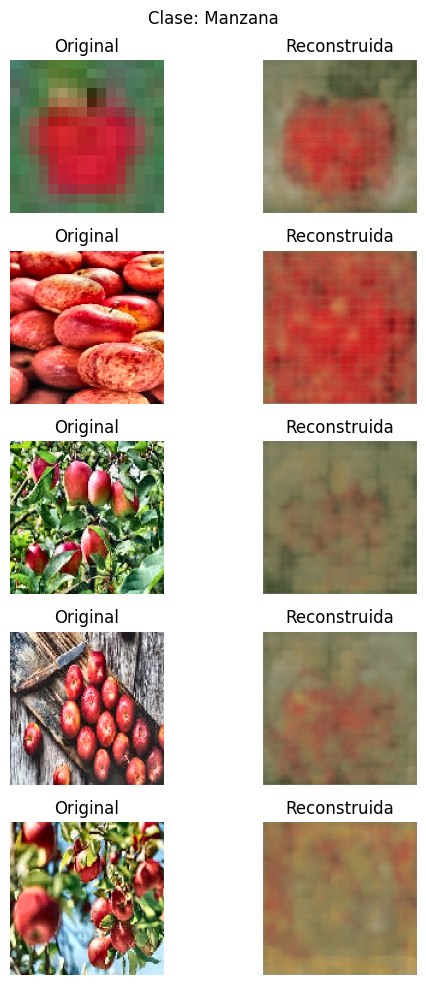

1/1 [==============================] - 0s 102ms/step


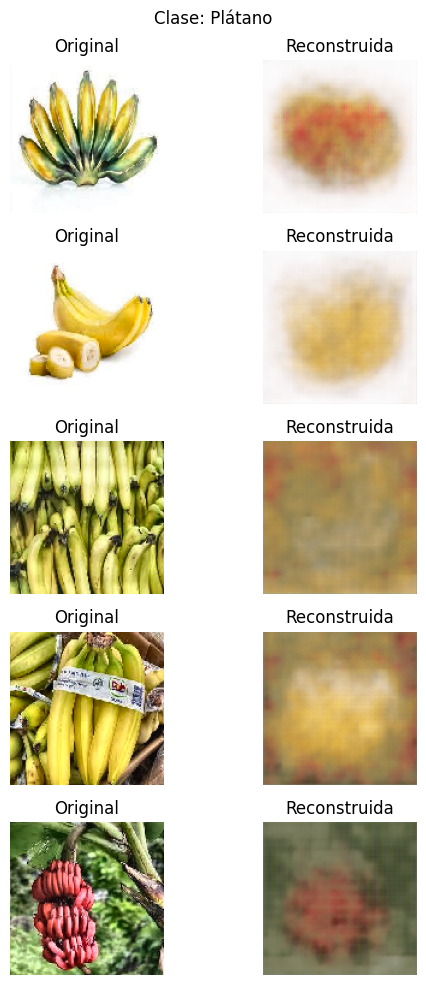

In [26]:
import matplotlib.pyplot as plt

def mostrar_imagenes_por_clase(vae, X, y, clase=0, cantidad=5):
    indices = np.where(y == clase)[0][:cantidad]
    imagenes = X[indices]
    reconstrucciones = vae.predict(imagenes)

    fig, axs = plt.subplots(cantidad, 2, figsize=(6, cantidad * 2))

    for i in range(cantidad):
        axs[i, 0].imshow(imagenes[i])
        axs[i, 0].set_title("Original")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(reconstrucciones[i])
        axs[i, 1].set_title("Reconstruida")
        axs[i, 1].axis("off")

    plt.suptitle(f"Clase: {'Manzana' if clase == 0 else 'Plátano'}")
    plt.tight_layout()
    plt.show()

# Mostrar 5 de cada clase
mostrar_imagenes_por_clase(vae, X_test, y_test, clase=0, cantidad=5)
mostrar_imagenes_por_clase(vae, X_test, y_test, clase=1, cantidad=5)


In [27]:
from google.colab import files

# Descargar los archivos
files.download("models/vae_encoder.h5")
files.download("models/vae_decoder.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## GIT ACTIONS CON GOOGLE COLAB

In [ ]:
!git config --global user.email "colomeab84@gmail.com"
!git config --global user.name "colome8"

In [ ]:
%cd /content/DAE-VAE
!git add trabajo_clonado.ipynb
!git commit -m "Modelos terminados"
!git push origin main